In [1]:
import keras
import os
os.environ['KERAS_BACKEND'] = 'theano'

In [2]:
THEANO_FLAGS='device=cuda'
floatX='float32'

In [20]:
import theano.sandbox.cuda
#root = './usr/local/cuda-7.0'
theano.sandbox.cuda.use("gpu0")

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.


In [4]:
from theano import function, config, shared, tensor
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], tensor.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, tensor.Elemwise) and
              ('Gpu' not in type(x.op).__name__)
              for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

[Elemwise{exp,no_inplace}(<TensorType(float64, vector)>)]
Looping 1000 times took 5.101286 seconds
Result is [ 1.23178032  1.61879341  1.52278065 ...,  2.20771815  2.29967753
  1.62323285]
Used the cpu


In [5]:
import theano

In [6]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1337)  # for reproducibility

from sklearn.datasets import make_swiss_roll

from theano import function
import matplotlib.patches as mpatches
from keras.datasets import mnist
from keras.models import Sequential
from numpy.random import normal
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Layer
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

from seya.layers.variational import VariationalDense as VAE
from seya.layers.convolutional import GlobalPooling2D
from seya.utils import apply_model
from seya.layers.regularization import ITLRegularizer
from seya.parzen import ParzenWindows

from agnez import grid2d, embedding2dplot
import math

Using Theano backend.


In [7]:
keras.__version__

'0.3.3'

In [8]:
import keras

In [9]:
# load mnist dataset and select four digital:'0','1','4','5'
img_rows, img_cols = 28, 28
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x4_train = x_train[np.where(y_train == 0)]
y4_train = y_train[np.where(y_train== 0)]
x4_test = x_test[np.where(y_test == 0)]
y4_test = y_test[np.where(y_test == 0)]
number=[1,4,5]
for i in number:
    x_temp_train = x_train[np.where(y_train == i)]
    y_temp_train = y_train[np.where(y_train == i)]
    x_temp_test = x_test[np.where(y_test == i)]
    y_temp_test = y_test[np.where(y_test == i)]
    x4_train = np.vstack((x4_train,x_temp_train))
    y4_train = np.hstack((y4_train,y_temp_train))
    x4_test = np.vstack((x4_test,x_temp_test))
    y4_test = np.hstack((y4_test,y_temp_test))

    
    
# shuffle data and split between train,validate and test sets
x4_train = x4_train.reshape(-1,784)
x4_test = x4_test.reshape(-1,784)
input_train = np.column_stack((x4_train,y4_train)) 
input_test = np.column_stack((x4_test,y4_test))
np.random.shuffle(input_train)
np.random.shuffle(input_test)
X_train = input_train[:,:784]
y_train = input_train[:,784]
X_test = input_test[:,:784]
y_test = input_test[:,784]
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255

X_valid = X_train[20000:]
X_train = X_train[:20000]

print('X_train shape',X_train.shape)
print('X_valid shape',X_valid.shape)
print('X_test shape',X_test.shape)

X_train shape (20000, 784)
X_valid shape (3928, 784)
X_test shape (3989, 784)


In [10]:
#add mix_Gaussian source noise
noise_v1 = 1
noise_v2 = 10
A = .1
noise_factor = 0.01
source_noise_train = (1-A) * normal(0, np.sqrt(noise_v1), X_train.shape) + A * normal(0, np.sqrt(noise_v2), X_train.shape)
source_noise_valid= (1-A) * normal(0, np.sqrt(noise_v1), X_valid.shape)  + A * normal(0, np.sqrt(noise_v2), X_valid.shape)
source_noise_test= (1-A) * normal(0, np.sqrt(noise_v1), X_test.shape) + A * normal(0, np.sqrt(noise_v2), X_test.shape)

x_train_noisy = X_train + noise_factor*source_noise_train
x_valid_noisy = X_valid + noise_factor*source_noise_valid
x_test_noisy = X_test + noise_factor*source_noise_test

In [11]:
# four Gaussian prior distribution
# size is the number of samples for each Gaussian
# scalar can change the distance between the Gaussian
mix_gaussian_scalar=2.
def gaussian_mixture_4(size, scalar=mix_gaussian_scalar):
    size = 400
    mean1 = [4.*scalar, 0.*scalar]
    mean2 = [0*scalar, 4*scalar]
    mean3 = [-4.*scalar, 0.*scalar]
    mean4 = [0.*scalar, -4.*scalar]

    cov1 = [[5., 0.], [0., 1.]]
    cov2 = [[1, 0], [0, 5]]
    cov3 = [[5., 0.], [0., 1.]]
    cov4 = [[1., 0.], [0., 5.]]

    X1 = np.random.multivariate_normal(mean1, cov1, size)
    X2 = np.random.multivariate_normal(mean2, cov2, size)
    X3 = np.random.multivariate_normal(mean3, cov3, size)
    X4 = np.random.multivariate_normal(mean4, cov4, size)

    X = K.concatenate([X1, X2, X3, X4], axis=0)
    return X

In [12]:
#add channel noise
def my_awgn(sig,SNR):
    sigPower= sum(sum(abs(sig)**2))/(sig.shape[0]*sig.shape[1])
    sigPower = 10*math.log10(sigPower)
    noisePower = sigPower - SNR
    p = 10**(noisePower/10)
    noise = (np.sqrt(p))*np.random.randn(sig.shape[0],sig.shape[1])
    noise_sig = sig + noise
    return noise_sig

In [13]:
#Principle of relevant information(pri)
pri_lambda = 5
pri_scale = 1
pri_ksize = 6.

# encoder architecture
enc = Sequential()
enc.add(Dense(1000, input_dim=784, activation='relu'))
enc.add(BN())
enc.add(Dense(1000, activation='relu'))
enc.add(BN())
enc.add(Dense(2))
enc.add(ITLRegularizer(distance='pri', scale=pri_scale, 
                       ksize=pri_ksize, pri_lambda=pri_lambda,
                       distribution=gaussian_mixture_4                      
                     ))
#decoder architecture
dec = Sequential()
dec.add(Dense(1000, input_dim=2, activation='relu'))
dec.add(Dense(784, activation='sigmoid'))

In [14]:
# complie model and use c-loss cost funciton and adam optimizer
#closs_ksize = 4.0
#ksize = closs_ksize
model = Sequential()
model.add(enc)
model.add(dec)
model.compile(loss='mse', optimizer='adam')
model.summary()

--------------------------------------------------------------------------------
Initial input shape: (None, 784)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Sequential (Unnamed)          (None, 2)                     1792002             
Sequential (Unnamed)          (None, 784)                   787784              
--------------------------------------------------------------------------------
Total params: 2579786
--------------------------------------------------------------------------------


In [15]:
# train and save the best model
cbk = ModelCheckpoint('mse_5.hdf5', 
                      save_best_only=True, verbose=True)
model.fit(x_train_noisy, X_train.reshape((-1, 784)), batch_size=800, 
                       nb_epoch=100, verbose=2,
                      validation_data=(x_valid_noisy, 
                      X_valid.reshape((-1, 784))),
                      callbacks=[cbk])

Train on 20000 samples, validate on 3928 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 0.07179, saving model to mse_5.hdf5
14s - loss: 12.9532 - val_loss: 0.0718
Epoch 2/100
Epoch 00001: val_loss improved from 0.07179 to 0.06137, saving model to mse_5.hdf5
12s - loss: 7.5542 - val_loss: 0.0614
Epoch 3/100
Epoch 00002: val_loss improved from 0.06137 to 0.05681, saving model to mse_5.hdf5
12s - loss: 5.3128 - val_loss: 0.0568
Epoch 4/100
Epoch 00003: val_loss improved from 0.05681 to 0.05599, saving model to mse_5.hdf5
12s - loss: 4.5932 - val_loss: 0.0560
Epoch 5/100
Epoch 00004: val_loss did not improve
12s - loss: 4.4390 - val_loss: 0.0564
Epoch 6/100
Epoch 00005: val_loss improved from 0.05599 to 0.05576, saving model to mse_5.hdf5
12s - loss: 4.4038 - val_loss: 0.0558
Epoch 7/100
Epoch 00006: val_loss improved from 0.05576 to 0.05554, saving model to mse_5.hdf5
12s - loss: 4.3084 - val_loss: 0.0555
Epoch 8/100
Epoch 00007: val_loss improved from 0.05554 to 0.05531, 

Epoch 00076: val_loss did not improve
15s - loss: 4.1025 - val_loss: 0.0517
Epoch 78/100
Epoch 00077: val_loss did not improve
15s - loss: 4.1099 - val_loss: 0.0516
Epoch 79/100
Epoch 00078: val_loss improved from 0.05135 to 0.05131, saving model to mse_5.hdf5
15s - loss: 4.1074 - val_loss: 0.0513
Epoch 80/100
Epoch 00079: val_loss improved from 0.05131 to 0.05118, saving model to mse_5.hdf5
15s - loss: 4.0938 - val_loss: 0.0512
Epoch 81/100
Epoch 00080: val_loss did not improve
15s - loss: 4.0990 - val_loss: 0.0513
Epoch 82/100
Epoch 00081: val_loss improved from 0.05118 to 0.05040, saving model to mse_5.hdf5
15s - loss: 4.0927 - val_loss: 0.0504
Epoch 83/100
Epoch 00082: val_loss did not improve
15s - loss: 4.1058 - val_loss: 0.0510
Epoch 84/100
Epoch 00083: val_loss did not improve
15s - loss: 4.0987 - val_loss: 0.0510
Epoch 85/100
Epoch 00084: val_loss did not improve
15s - loss: 4.0956 - val_loss: 0.0510
Epoch 86/100
Epoch 00085: val_loss did not improve
15s - loss: 4.1063 - val_l

In [16]:
X = K.placeholder(ndim=2)
Y = dec(X)
F_dec = function([X], Y, allow_input_downcast=True)
X = K.placeholder(ndim=2)
Y = enc(X)
F_enc = function([X], Y, allow_input_downcast=True)

Text(0.5, 1.0, 'channel_noise = 14dB')

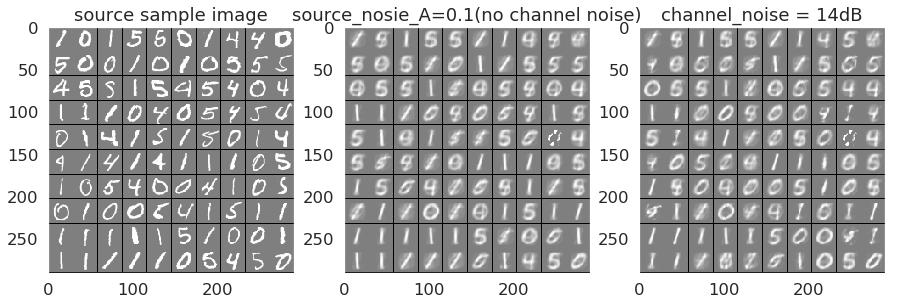

In [17]:
#use source noise as input
y = F_enc(x_train_noisy[:100])
#add channel noise
y_noisy = my_awgn(y,14)
y_dec = F_dec(y)#source 
y_noise_dec = F_dec(y_noisy)# add channel noise
plt.figure(figsize = (15,8))
#no channel noise
I_source_noise = grid2d(y_dec.reshape((100, -1)))
#channel noise
I_channel_noise = grid2d(y_noise_dec.reshape((100, -1)))
#source sample images
I = grid2d(X_train[:100].reshape((100, -1)))
plt.subplot(1,3,1)
plt.imshow(I, cmap='gray')
plt.title('source sample image')
plt.subplot(1,3,2)
plt.imshow(I_source_noise, cmap='gray')
plt.title('source_nosie_A=0.1(no channel noise)')
plt.subplot(1,3,3)
plt.imshow(I_channel_noise, cmap='gray')
plt.title('channel_noise = 14dB')

(-15, 15)

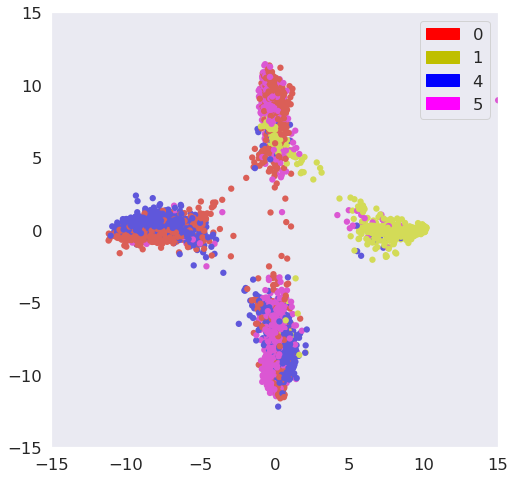

In [18]:
#Bottleneck layer codes visualization
y = F_enc(X_train[:6000])
_ = embedding2dplot(y, y_train[:6000], show_median=False)
five_patch = mpatches.Patch(color='magenta', label='5')
four_patch = mpatches.Patch(color='blue', label='4')
one_patch = mpatches.Patch(color='y', label='1')
zero_patch = mpatches.Patch(color='red', label='0')
plt.legend(handles=[zero_patch,one_patch,four_patch,five_patch])
plt.axis('on')
plt.xlim(-15, 15)
plt.ylim(-15, 15)